In [36]:
from TumorGrowthToolkit.FK_2c import Solver
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import time
import scipy.ndimage

# Plotting function
def plot_tumor_states(wm_data, initial_states, final_states, slice_index, cmap1, cmap2, cmap3):
    plt.figure(figsize=(18, 6))  # Adjusted figure size for 3 columns

    # Fields to plot
    fields = ['P', 'N', 'S']
    titles = ['Proliferative Cells', 'Necrotic Cells', 'Nutrient Field']

    # Plotting initial states
    for i, field in enumerate(fields):
        plt.subplot(2, 3, i + 1)
        plt.imshow(wm_data[:, :, slice_index], cmap=cmap1, vmin=0, vmax=1, alpha=1)
        plt.imshow(initial_states[field][:, :, slice_index], cmap=cmap2 if i == 0 else cmap3, vmin=0, vmax=1, alpha=0.65)
        plt.title(f"Initial {titles[i]}")

    # Plotting final states
    for i, field in enumerate(fields):
        plt.subplot(2, 3, i + 4)
        plt.imshow(wm_data[:, :, slice_index], cmap=cmap1, vmin=0, vmax=1, alpha=1)
        plt.imshow(final_states[field][:, :, slice_index], cmap=cmap2 if i == 0 else cmap3, vmin=0, vmax=1, alpha=0.65)
        plt.title(f"Final {titles[i]}")

    plt.tight_layout()
    plt.show()
    

def plot_time_series(wm_data, time_series_data, slice_index, cmap1, cmap2, cmap3):
    plt.figure(figsize=(10, 24))  # Adjusted figure size for multiple rows

    # Fields to plot
    fields = ['P', 'N', 'S']
    field_titles = ['Proliferative', 'Necrotic', 'Nutrient']

    # Generate indices for selected timesteps
    # Assuming time_series_data for each field is an array where the first dimension is time
    num_timesteps = np.array(time_series_data['P']).shape[0]
    time_points = np.linspace(0, num_timesteps - 1, 8, dtype=int)

    for i, t in enumerate(time_points):
        for j, field in enumerate(fields):
            plt.subplot(len(time_points), 3, i * 3 + j + 1)
            plt.imshow(wm_data[:, :, slice_index], cmap=cmap1, vmin=0, vmax=1, alpha=1)
            plt.imshow(np.array(time_series_data[field])[t, :, :, slice_index], cmap=cmap2 if j == 0 else cmap3, vmin=0, vmax=1, alpha=0.65)
            plt.title(f"Time Slice {t + 1} - {field_titles[j]}")

    plt.tight_layout()
    plt.show()

# Generate base random data
base_data = np.random.rand(100, 100, 100)
# Apply a Gaussian filter for smooth transitions
wm_data = scipy.ndimage.gaussian_filter(base_data, sigma=3)
# Ensure gm_data is normalized between 0 and 1
wm_data = (wm_data - np.min(wm_data)) / (np.max(wm_data) - np.min(wm_data))
wm_data = wm_data*wm_data
# Calculate white matter data as the complementary probability
gm_data = 1 - wm_data

In [37]:
# Set up parameters
parameters = {
    'Dw': 1.5,          # Diffusion coefficient for the white matter
    'rho': 0.08,         # Proliferation rate
    'lambda_np': 0.5, # Transition rate between proli and necrotic cells
    'sigma_np': 0.5, #Transition threshols between proli and necrotic given nutrient field
    'D_s': 3.0,      # Diffusion coefficient for the nutrient field
    'lambda_s': 0.1, # Proli cells nutrients consumption rate
    'RatioDw_Dg': 100,  # Ratio of diffusion coefficients in white and grey matter
    'Nt_multiplier': 10,
    'gm': gm_data,      # Grey matter data
    'wm': wm_data,      # White matter data
    'NxT1_pct': 0.5,    # tumor position [%]
    'NyT1_pct': 0.6,
    'NzT1_pct': 0.5,
    'init_scale': 1., #scale of the initial gaussian
    'resolution_factor': 0.4, #resultion scaling for calculations
    'th_matter': 0.1, #when to stop diffusing: at th_matter > gm+wm
    'verbose': True, #printing timesteps 
    'time_series_solution_Nt': 64 # number of timesteps in the output
    
}

# Run the FK_solver and plot the results
start_time = time.time()
fk_solver = Solver(parameters)
result = fk_solver.solve()
end_time = time.time()  # Store the end time
execution_time = int(end_time - start_time)  # Calculate the difference
print(f"Execution Time: {execution_time} seconds")

Number of simulation timesteps: 292
Execution Time: 6 seconds


Simulation successful!


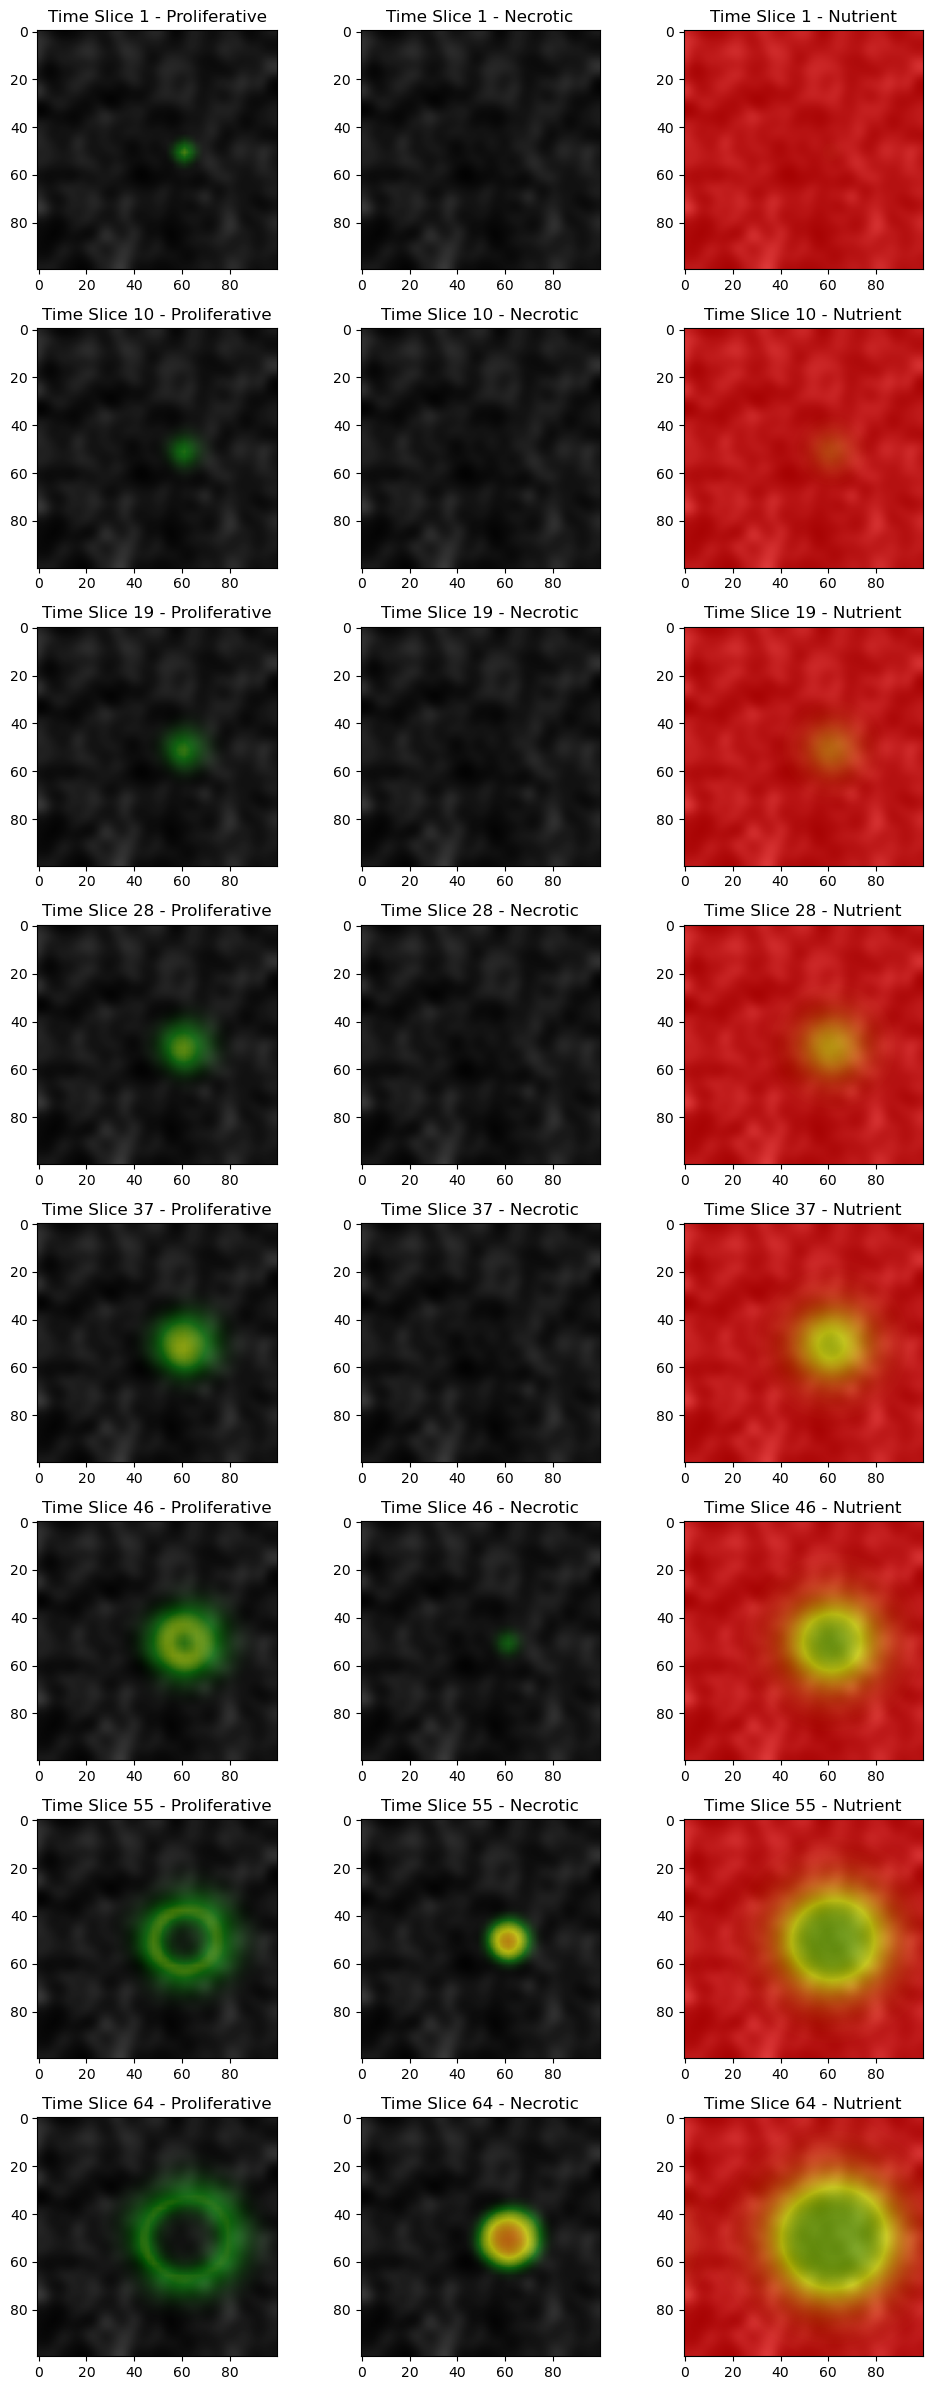

In [38]:
# Calculate the slice index
NzT = int(parameters['NzT1_pct'] * gm_data.shape[2])
# Create custom color maps
cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list('my_cmap', ['black', 'white'], 256)
cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list('my_cmap2', ['black', 'green', 'yellow', 'red'], 256)

if result['success']:
    print("Simulation successful!")
    # Extract initial and final states from the result
    #initial_states = result['initial_state']
    #final_states = result['final_state']
    #plot_tumor_states(wm_data, initial_states, final_states, NzT, cmap1, cmap2, cmap2)
    time_series_data = result['time_series']
    plot_time_series(wm_data, time_series_data, NzT, cmap1, cmap2, cmap2)
else:
    print("Error occurred:", result['error'])